In [1]:
import pandas as pd, numpy as np, mglearn, numpy.linalg as nl, inspect, seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
#Preparing data
train_data = pd.read_csv('Data/spam_train.csv',index_col=0)
test_data = pd.read_csv('Data/spam_test.csv',index_col=0)
XCOL = train_data.columns.drop('class')
YCOL = 'class'

#Preparing Necessary Variables
out_dir = Path('output')
res_dir = Path('results')
res_dir.mkdir(exist_ok=True)
train_model = True
save = True
train_data

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
3009,0.07,0.00,0.07,0.0,0.00,0.00,0.00,0.46,0.69,0.00,...,0.142,0.175,0.032,0.000,0.021,0.000,3.007,60,791,0
798,0.00,0.00,0.74,0.0,1.85,0.37,0.37,0.00,0.00,0.74,...,0.000,0.264,0.000,0.000,0.000,0.000,2.492,12,172,1
4396,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.763,0.000,2.181,6,24,0
353,0.00,0.00,0.32,0.0,0.65,0.65,0.32,0.32,0.00,0.00,...,0.000,0.105,0.000,0.000,0.158,0.000,1.494,10,139,1
574,1.03,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.176,0.176,0.000,2.766,26,83,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1,4,0
602,0.00,0.58,0.58,0.0,0.00,0.00,0.00,0.58,0.58,7.55,...,0.000,0.192,0.000,0.192,0.000,0.096,1.526,10,58,1
167,0.00,0.71,0.35,0.0,0.35,0.00,0.00,0.00,0.00,0.00,...,0.000,0.058,0.000,0.700,0.000,0.000,3.768,61,260,1
1314,0.54,0.13,0.38,0.0,0.05,0.19,0.00,0.05,0.35,0.16,...,0.000,0.086,0.000,0.273,0.150,0.159,6.789,195,3327,1


In [3]:
#General Functions
def ty_normalize(train_df,test_df):
    train, test = train_df.copy(), test_df.copy()
    scaler = StandardScaler()
    scaler.fit(train[XCOL])
    train[XCOL] = normalize(scaler.transform(train[XCOL]))
    test[XCOL] = normalize(scaler.transform(test[XCOL]))
    return train, test

def make_df(model_list,opt_list):
    #Edited from my final last semester for simpler models
    #Since not all models require the same option lists, we can run this on each pairing and merge.
    result = []
    for model_gen in model_list:
        for option in opt_list:
            model_id, model = model_gen(option)
            result.append([f'{model_id}_{option:.2f}', model_id, model,option])
    return pd.DataFrame(columns = ['ID','Model_ID','Model', 'Attribute'],data=result)


def knn(neighbor):
    return inspect.stack()[0][3], KNeighborsClassifier(n_neighbors=int(neighbor)) #I know this can cause issues, but it's worth it for this.
def logistic(C):
    return inspect.stack()[0][3], LogisticRegression(C=C)
def svm(C):
    return inspect.stack()[0][3], SVC(C=C,probability=True)

def basic_analysis(model, train_data,test_data):
    #Normalize data beforehand
    model.fit(train_data[XCOL],train_data[YCOL])
    return [model.score(train_data[XCOL],train_data[YCOL]),model.score(test_data[XCOL],test_data[YCOL])]

    

def cval(row, train_data, test_data, save=False, outdir=''):
    #Need to normalize inside of here for the cval splits
    cval_res = pd.DataFrame.from_dict(cross_validate(row['Model'], train_data[XCOL],train_data[YCOL], cv=5,return_train_score=True))
    cval_res = cval_res[['train_score','test_score']].reset_index().rename(columns={"index":"Split","train_score":"train","test_score":"test"})
    cval_res['Model_ID'] = row['Model_ID']
    cval_res['Attribute'] = row['Attribute']
    if save:
        out = Path(outdir,row['Model_ID'],row['ID'])
        if not out.is_dir():
            out.mkdir(parents=True)
        cval_res.to_csv(Path(out,'cval.csv'),index=False)
        cval_res.style.to_latex(Path(out,'cval.tex'))
    # test_result = cval_result['test_score']
    # train_result = cval_result['train_score']
    return cval_res
    # return test_result, train_result
    

    
    

#Create a scatterplot of train/test accuracy for each of the 5 folds for each model/option pair 
#Bruh just use the cross_val_predict/cross_val_score option.







In [4]:
train, test = ty_normalize(train_data,test_data)

log_options = np.linspace(0,10,101)[1:]
svm_options = np.linspace(0,10,101)[1:]
neighbors = np.arange(1,101)


model_df = pd.concat([make_df([knn],neighbors),make_df([svm],svm_options),make_df([logistic],log_options)])
model_df

,ID,Model_ID,Model,Attribute
0,knn_1.00,knn,KNeighborsClassifier(n_neighbors=1),1.0
1,knn_2.00,knn,KNeighborsClassifier(n_neighbors=2),2.0
2,knn_3.00,knn,KNeighborsClassifier(n_neighbors=3),3.0
3,knn_4.00,knn,KNeighborsClassifier(n_neighbors=4),4.0
4,knn_5.00,knn,KNeighborsClassifier(),5.0
...,...,...,...,...
95,logistic_9.60,logistic,LogisticRegression(C=9.600000000000001),9.6
96,logistic_9.70,logistic,LogisticRegression(C=9.700000000000001),9.7
97,logistic_9.80,logistic,LogisticRegression(C=9.8),9.8
98,logistic_9.90,logistic,LogisticRegression(C=9.9),9.9


In [5]:
if train_model:
    res = pd.concat([cval(row,train,test, save=save, outdir=out_dir) for _,row in tqdm(model_df.iterrows(),total=model_df.shape[0])]).reset_index(drop=True)
else:
    res = pd.read_csv(Path(res_dir,'full_results.csv'))

In [6]:
grouped = res.groupby(["Model_ID","Attribute"])[['train','test']]

In [13]:
def seaborn_friendly(res):
    train_only = res.drop(columns='test').rename(columns={"train":"Accuracy"})
    train_only['type'] = 'train'
    test_only = res.drop(columns='train').rename(columns={"test":"Accuracy"})
    test_only['type'] = 'test'
    return pd.concat([train_only, test_only]).reset_index(drop=True)
def plot_analysis(res, save=False, outdir='.'):
    analyzed = res.groupby(["Model_ID","Attribute"])[['train','test']].agg([np.mean,np.std])
    analyzed.columns = ['_'.join(col) for col in analyzed.columns.values]
    analyzed.reset_index(inplace=True)
    best = get_best(analyzed)
    if save:
        best.to_csv(Path(outdir,"Best.csv"))
        analyzed.to_csv(Path(outdir,"Processed_results.csv"),index=False)
        res.to_csv(Path(outdir,"full_results.csv"),index=False)
        best.to_latex(Path(outdir,"Best.tex"))
        analyzed.to_latex(Path(outdir,"Processed_results.tex"),index=False)
        res.to_latex(Path(outdir,"full_results.tex"),index=False)
    ax = sns.scatterplot(x='train_mean',y='test_mean',data=analyzed, hue="Model_ID")
    ax.set(title="Overall Performance By Model")
    if save:
        ax.get_figure().savefig(Path(outdir,"Full_Scatter.png"))
    show()
    sea = seaborn_friendly(res)
    for name, group in sea.groupby("Model_ID"):
        ax = sns.lineplot(data=group, x="Attribute",y="Accuracy",hue="type",errorbar="sd")
        ax.set(title="{} Performance".format(name))
        show()
        if save:
            ax.get_figure().savefig(Path(outdir,"{}_Performance.png".format(name)))
    return best
    
def get_best(data):
    return data.iloc[data.groupby("Model_ID")["test_mean"].idxmax()]

def make_best_apply(row,**kwargs):
    lazy_dict = {'logistic':logistic,'knn':knn,'svm':svm}
    func = lazy_dict[row['Model_ID']](row['Attribute'])[1]
    func.fit(kwargs['train_data'][XCOL],kwargs['train_data'][YCOL])
    return pd.Series(index = ['Model_ID','Attribute','Final_Perf','Cval_Perf','Model'],data = [row['Model_ID'],row['Attribute'],func.score(kwargs['test_data'][XCOL],kwargs['test_data'][YCOL]),row['test_mean'],func])



def test_result(df,test,train, save=False, outdir=''):
    final = df.apply(make_best_apply,axis=1,test_data=test,train_data=train)
    
    if save:
        final.drop(columns=['Model']).to_csv(Path(outdir,"Final.csv"),index=False)
        final.drop(columns=['Model']).to_latex(Path(outdir,"Final.tex"),index=False)
    return final
    

/tmp/ipykernel_369/4027526110.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  best.to_latex(Path(outdir,"Best.tex"))
/tmp/ipykernel_369/4027526110.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  analyzed.to_latex(Path(outdir,"Processed_results.tex"),index=False)
/tmp/ipykernel_369/4027526110.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments s

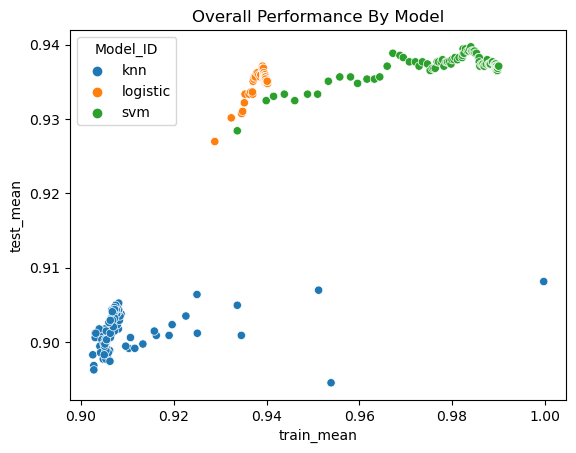

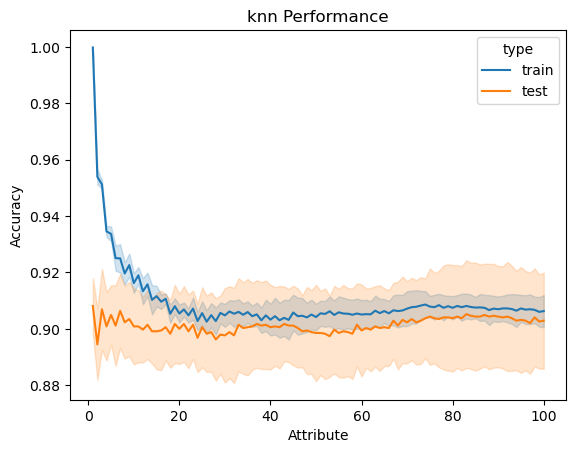

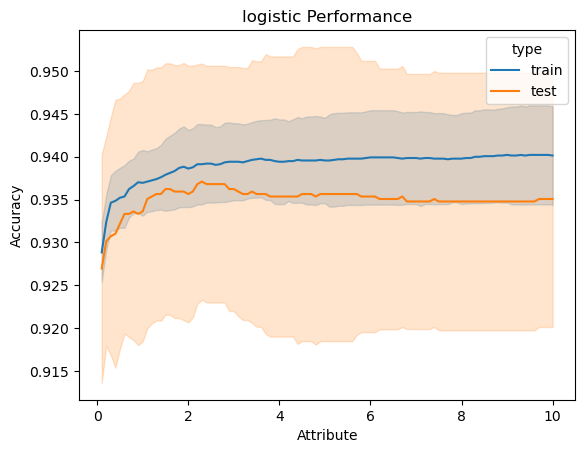

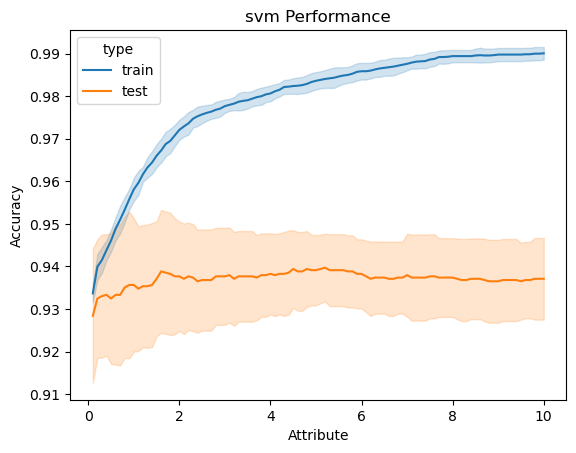

/tmp/ipykernel_369/4027526110.py:48: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  final.to_latex(Path(outdir,"Final.tex"),index=False)


,Model_ID,Attribute,Final_Perf,Cval_Perf,Model
0,knn,1.0,0.902693,0.908116,KNeighborsClassifier(n_neighbors=1)
122,logistic,2.3,0.925282,0.937101,LogisticRegression(C=2.3000000000000003)
251,svm,5.2,0.934839,0.939710,SVC(C=5.2)


In [24]:
best = plot_analysis(res,save=save,outdir=res_dir)
final = test_result(best,test,train,save=save, outdir=res_dir)
final

In [35]:

#Get called/truth binary data into a df, and the class score value into a df. Plot the 3 different classes into 3D
def missed_prep(final,test,save=False,outdir='.'):
    missed_df = pd.DataFrame(columns=final['Model_ID'])
    missed_df['truth'] = test[YCOL]
    score_df = missed_df.copy()
    for idx, row in final.iterrows():
        func = row['Model']
        name = row['Model_ID']
        predictions = func.predict_proba(test[XCOL])
        score_df[name] = predictions[:,1]
        missed_df[name] = predictions.argmax(axis=1)
    if save:
        score_df.to_csv(Path(outdir,'scores.csv'))
        missed_df.to_csv(Path(outdir,'binary_result.csv'))
    return missed_df, score_df

In [37]:
#binary, scores = missed_prep(final,test)
eh = final.iloc[-1]['Model']

In [38]:
bleh = eh.predict_proba(test[XCOL])

AttributeError: predict_proba is not available when  probability=False

In [34]:
bleh.argmax(axis=1)

array([0, 0, 1, ..., 1, 1, 1])

In [30]:
eh.predict(test[XCOL]) 

array([0, 0, 1, ..., 1, 1, 1])